### Predicción de Suscripción de Depósito a Plazo Fijo (Neural Network NN)
Intentaremos mejorar la precisión de nuestro modelo usando una herramiento que captura mejor las no linealidades de los datos, es decir una NN.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2025-08-13 18:03:06.686764: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-13 18:03:06.747813: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Cargar datos
df = pd.read_csv('datasets/bank-additional-full.csv', delimiter=';')
print(df.dtypes)

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object


In [3]:
# Codificar variable objetivo binaria
df['y_encoded'] = df['y'].map({'no': 0, 'yes': 1})

# Seleccionar features numéricas y convertir categóricas a numéricas con Label Encoding sencillo
df_encoded = df.copy()
for col in df_encoded.select_dtypes(include='object').columns:
    if col != 'y':  # evitar la target original
        df_encoded[col] = df_encoded[col].astype('category').cat.codes

print(df_encoded.dtypes)

age                 int64
job                  int8
marital              int8
education            int8
default              int8
housing              int8
loan                 int8
contact              int8
month                int8
day_of_week          int8
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome             int8
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
y_encoded           int64
dtype: object


In [4]:
# Definir X, y
X = df_encoded.drop(columns=['y', 'y_encoded'])
y = df_encoded['y_encoded']

# Dividir en train y val
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15/0.85, random_state=42)

# Escalar features (muy importante para NN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Calcular class weights para balancear el dataset
y_train_array = y_train.values  # convertir a numpy array

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_array),
    y=y_train_array
)
class_weight_dict = dict(enumerate(class_weights))

In [5]:
# Modelo mejorado
model = Sequential([
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.2),
    
    Dense(1, activation='sigmoid')
])

# Compilación
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks para optimización
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-5
)

# Entrenamiento
history = model.fit(
    X_train_scaled,
    y_train_array,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

# Evaluación
loss, acc = model.evaluate(X_val_scaled, y_val, verbose=0)
print(f"Exactitud en validación: {acc:.4f}")

/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
901/901 - 6s - 7ms/step - accuracy: 0.7584 - loss: 0.5456 - val_accuracy: 0.8139 - val_loss: 0.4377 - learning_rate: 0.0010
Epoch 2/100
901/901 - 2s - 2ms/step - accuracy: 0.8129 - loss: 0.4425 - val_accuracy: 0.8278 - val_loss: 0.3884 - learning_rate: 0.0010
Epoch 3/100
901/901 - 2s - 2ms/step - accuracy: 0.8104 - loss: 0.4217 - val_accuracy: 0.8103 - val_loss: 0.4129 - learning_rate: 0.0010
Epoch 4/100
901/901 - 2s - 2ms/step - accuracy: 0.8132 - loss: 0.4004 - val_accuracy: 0.8270 - val_loss: 0.3749 - learning_rate: 0.0010
Epoch 5/100
901/901 - 2s - 2ms/step - accuracy: 0.8185 - loss: 0.3811 - val_accuracy: 0.8066 - val_loss: 0.3825 - learning_rate: 0.0010
Epoch 6/100
901/901 - 2s - 2ms/step - accuracy: 0.8198 - loss: 0.3758 - val_accuracy: 0.8296 - val_loss: 0.3602 - learning_rate: 0.0010
Epoch 7/100
901/901 - 2s - 2ms/step - accuracy: 0.8166 - loss: 0.3663 - val_accuracy: 0.8263 - val_loss: 0.3662 - learning_rate: 0.0010
Epoch 8/100
901/901 - 2s - 2ms/step - accuracy: 

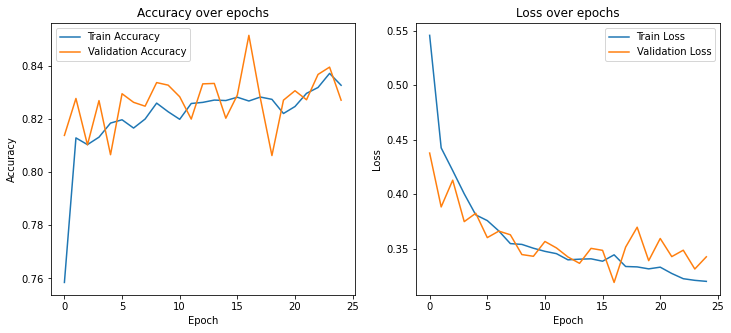

901/901 ━━━━━━━━━━━━━━━━━━━━ 1s 931us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
Train accuracy (TensorFlow): 0.8533
Validation accuracy (TensorFlow): 0.8516


In [8]:
# Gráficos de accuracy y loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')

plt.show()


# Predecir probabilidades
y_train_probs = model.predict(X_train_scaled)
y_val_probs = model.predict(X_val_scaled)

# Convertir probabilidades a clases (umbral 0.5)
y_train_pred = (y_train_probs >= 0.5).astype(int).flatten()
y_val_pred = (y_val_probs >= 0.5).astype(int).flatten()

# Calcular accuracy con sklearn
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

print(f"Train accuracy (TensorFlow): {train_acc:.4f}")
print(f"Validation accuracy (TensorFlow): {val_acc:.4f}")

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
=== Classification Report (Test Set) ===
              precision    recall  f1-score   support

           0       0.99      0.83      0.90      5478
           1       0.41      0.92      0.57       701

    accuracy                           0.84      6179
   macro avg       0.70      0.88      0.74      6179
weighted avg       0.92      0.84      0.87      6179

=== Confusion Matrix (Test Set) ===
[[4573  905]
 [  59  642]]
AUC (Test Set): 0.9414


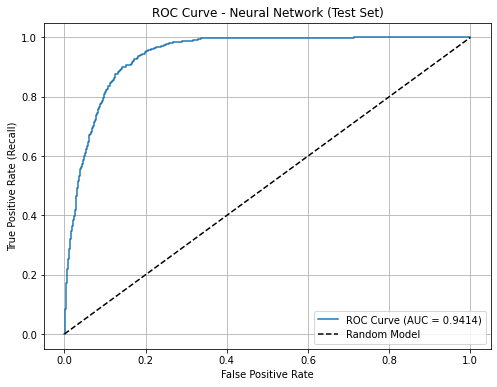

In [11]:
# Probabilidades y predicciones para test set ---
y_test_probs = model.predict(X_test_scaled).ravel()
y_test_pred = (y_test_probs >= 0.5).astype(int)  # Umbral estándar 0.5

# Classification report
print("=== Classification Report (Test Set) ===")
print(classification_report(y_test, y_test_pred))

# Matriz de confusión
print("=== Confusion Matrix (Test Set) ===")
print(confusion_matrix(y_test, y_test_pred))

# ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
auc_score = roc_auc_score(y_test, y_test_probs)
print(f"AUC (Test Set): {auc_score:.4f}")

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Model')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve - Neural Network (Test Set)")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Conclusiones finales: Neural Networks vs Logistic Regression

**1. Mejora general del modelo**  
- La **Neural Network (NN)** alcanzó un **accuracy de 0.84**, frente a **0.79** de Logistic Regression, mejorando **≈5 puntos porcentuales** en predecir correctamente tanto positivos como negativos.  
- El **weighted average** de precisión y recall también mejora:  
  - NN: precisión **0.92**, recall **0.84**  
  - Logistic: precisión **0.92**, recall **0.79**  

**2. Detección de clientes potenciales (clase positiva)**  
- **Recall clase 1 (suscriptores):**  
  - NN: **92%**, Logistic: **95%** → casi todos los clientes interesados son detectados (92 de cada 100 según NN).  
- **Precisión clase 1:**  
  - NN: **41%**, Logistic: **35%** → NN reduce los falsos positivos un 6%.  

**3. F1-score (balance precisión y recall)**  
- NN: **0.57** vs Logistic: **0.51** para clase positiva → mejor equilibrio en la detección de clientes que suscriben.

**4. Clase negativa (no suscriptores)**  
- NN: precisión **0.99**, recall **0.83**  
- Logistic: precisión **0.99**, recall **0.77**  
→ La NN identifica correctamente más no suscriptores, reduciendo contactos innecesarios (falsos positivos).

**5. Curva ROC y AUC**  
- NN: **AUC ≈ 0.9014**  
- Logistic: **AUC ≈ 0.935**  
→ Ambas muestran excelente discriminación, pero Logistic logra ligeramente un mejor balance

**Conclusión estratégica:**  
La **NN mantiene un recall alto para clientes interesados (92%)**, mejora la precisión y el F1-score respecto a Logistic Regression, y optimiza la identificación de clientes no interesados. Esto permite maximizar la captación de clientes potenciales y reducir costos de campaña.


### Conclusions: Neural Network vs Logistic Regression

**1. Overall Model Improvement**  
- The **Neural Network (NN)** achieved an **accuracy of 0.84**, compared to **0.79** for Logistic Regression, improving by **≈5 percentage points** in correctly predicting both positives and negatives.  
- The **weighted average** of precision and recall also improves:  
  - NN: precision **0.92**, recall **0.84**  
  - Logistic: precision **0.92**, recall **0.79**  

**2. Detection of Potential Customers (Positive Class)**  
- **Recall for class 1 (subscribers):**  
  - NN: **92%**, Logistic: **95%** → almost all interested customers are detected (92 out of 100 according to NN).  
- **Precision for class 1:**  
  - NN: **41%**, Logistic: **35%** → NN reduces false positives by 6%.  

**3. F1-score (Balance between Precision and Recall)**  
- NN: **0.57** vs Logistic: **0.51** for the positive class → better balance in detecting subscribing customers.

**4. Negative Class (Non-subscribers)**  
- NN: precision **0.99**, recall **0.83**  
- Logistic: precision **0.99**, recall **0.77**  
→ The NN correctly identifies more non-subscribers, reducing unnecessary contacts (false positives).

**5. ROC Curve and AUC**  
- NN: **AUC ≈ 0.9014**  
- Logistic: **AUC ≈ 0.935**  
→ Both demonstrate excellent discrimination, although Logistic achieves a slightly better balance.

**Strategic Conclusion:**  
The **NN maintains a high recall for interested customers (92%)**, improves precision and F1-score compared to Logistic Regression, and optimizes identification of non-interested customers. This enables maximizing potential customer acquisition while reducing campaign costs.

